In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import scipy.stats as st
import pickle

from egg.palettes import palettes

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
import numpy.typing as npt

sns.set_context("talk")


def plot(x, y, ax=None, c="#1E88E5", text_y=40):
    if ax is None:
        ax = plt.gca()

    if not isinstance(x, np.ndarray):
        x = x.to_numpy()

    if not isinstance(y, np.ndarray):
        y = y.to_numpy()

    huber = HuberRegressor(fit_intercept=False, epsilon=1.1)
    huber.fit(x[..., None], y)
    coef = huber.coef_[0]

    ax.plot([0, 50], [0, 50], c="tab:gray", ls="--", lw=2)
    ax.plot([0, 50], [0, 50 * coef], c="k", lw=2)
    ax.scatter(x, y, s=30, c=c, zorder=10)
    ax.axis("equal")
    ax.text(5, text_y, f"$r(x) = {coef:.2f}x$")


def get_scores(run_id):
    api = wandb.Api()
    run = api.run(f"sinzlab/egg/{run_id}")
    history = run.history()

    return history

230
710
901
1118


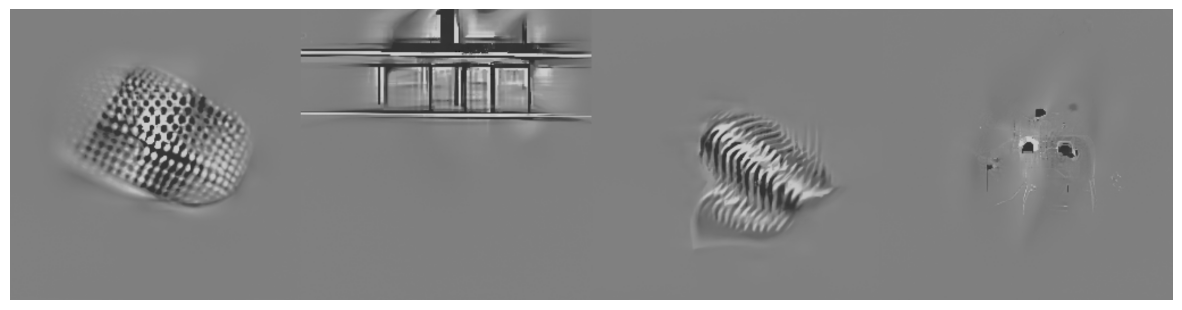

In [148]:
history = get_scores('6knyualn')
idx = history.groupby(["unit_idx"])["train"].idxmin()
color = history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image", "g_image"]]

images = []
g_images = []
api = wandb.Api()
for idx, unit in color.iterrows():
    image = unit['image']['path']
    g_image = unit['g_image']['path']
    print(unit['unit_idx'])
    run = api.run(f"sinzlab/egg/6knyualn")
    image = Image.open(run.file(image).download(exist_ok=True).name)
    images.append(np.array(image))

    g_image = Image.open(run.file(g_image).download(exist_ok=True).name)
    g_images.append(np.array(g_image))

images = np.array(images)

sns.set_context('talk')
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images[:4]))
plt.axis('off')
plt.grid(False)
plt.savefig(f'./results/color.png', dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()
#
sns.set_context('talk')
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(g_images), cmap='gray')
plt.axis('off')
plt.grid(False)
plt.savefig(f'./results/gray.png', dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

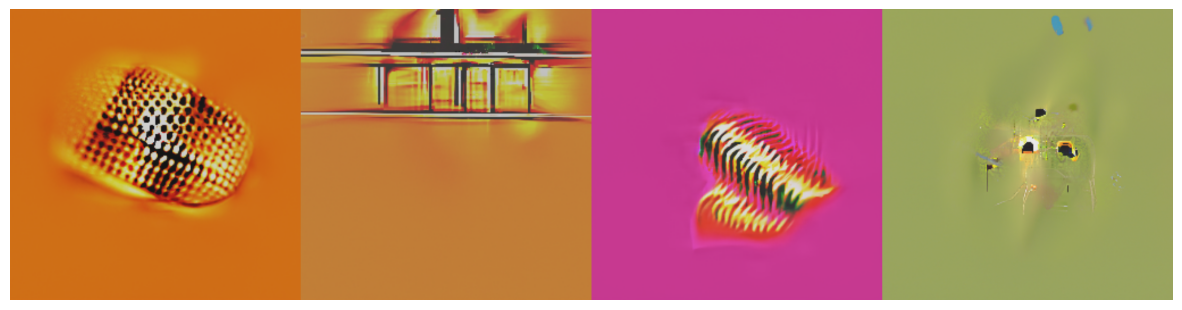

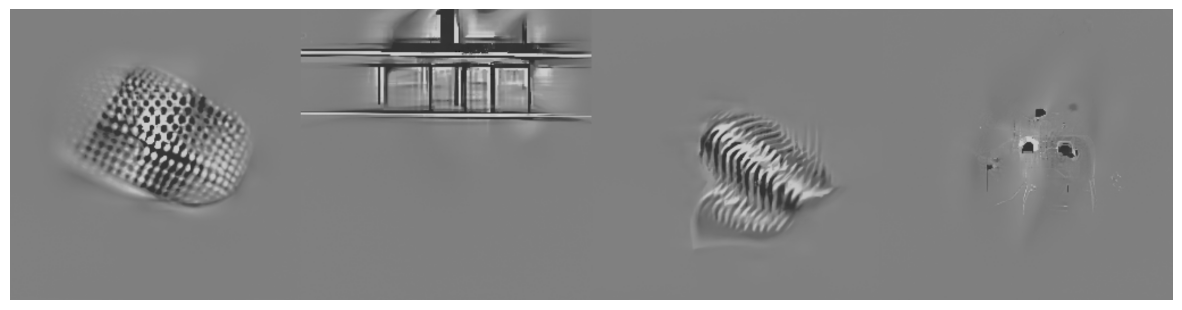

In [149]:
sns.set_context('talk')
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(images[:4]))
plt.axis('off')
plt.grid(False)
plt.savefig(f'./results/color.png', dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()
#
sns.set_context('talk')
plt.figure(figsize=(15, 4))
plt.imshow(np.hstack(g_images), cmap='gray')
plt.axis('off')
plt.grid(False)
plt.savefig(f'./results/gray.png', dpi=150, bbox_inches='tight', pad_inches=0)
plt.show()

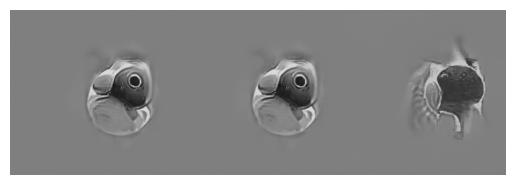

In [139]:
history = get_scores("edh6eed0")
api = wandb.Api()
units = [39]

for unit in units:
    images = history.query(f'unit_idx == {unit}')['image'].apply(lambda x: x['path'])
    run = api.run(f"sinzlab/egg/edh6eed0")
    images = [np.array(Image.open(run.file(image).download(exist_ok=True).name)) for image in images][:3]

    sns.set_context('talk')
    plt.imshow(np.hstack(images))
    plt.axis('off')
    plt.grid(False)
    plt.savefig(f'./results/egg_td_{unit}.png', dpi=150, bbox_inches='tight')
    plt.show()



# Task-Driven ResNet + Gaussian Readout Model

## Get the data
Get the EGG MEIs (DIMEs) and GA MEIs

Get the MEIs and choose the seeds which perform best on train

In [250]:
with open('../data/data_driven_corrs.pkl', 'rb') as f:
    data_driven_corrs = pickle.load(f)

history = get_scores("dxuyo5r1")
idx = history.groupby(["unit_idx"])["train"].idxmin()
dimes = history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]]

# mei_history = get_scores("h83eq1s8")
mei_history = get_scores("c0yeuwwy")
idx = mei_history.groupby(["unit_idx"])["train"].idxmin()
meis = mei_history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]]

mei_dime = dimes.merge(meis, on="unit_idx", how="right", suffixes=["_d", "_m"])
mei_dime = mei_dime.merge(data_driven_corrs, left_on="unit_idx", right_on="unit_id")


mei100_history = get_scores("fcv612lm")
idx = mei100_history.groupby(["unit_idx"])["train"].idxmin()
meis100 = mei100_history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]]

meis100 = meis.merge(meis100, on="unit_idx", how="right", suffixes=["_1000", "_100"])
# meis100 = meis100.merge(data_driven_corrs, left_on="unit_idx", right_on="unit_id")

meiw_history = get_scores("s6qk78fo")
idx = meiw_history.groupby(["unit_idx"])["train"].idxmin()
meisw = meiw_history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]]

meisw = meis.merge(meisw, on="unit_idx", how="right", suffixes=["_sgd", "_w"])


# mein_history = get_scores("ylxh7l3l")
mein_history = get_scores("q1v64jln")
idx = mein_history.groupby(["unit_idx"])["train"].idxmin()
meisn = mein_history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image", "norm"]]

# meisn = meis.merge(meisn, on="unit_idx", how="right", suffixes=["_sgd", "_w"])

In [ ]:
from egg.models import models

In [300]:
import torch.nn.functional as F
import torch
from tqdm import tqdm

acts = []

for i in tqdm(range(len(meis))):
    image = meis.iloc[i]['image']['path']
    unit_idx = meis.iloc[i]['unit_idx']

    run = api.run(f"sinzlab/egg/c0yeuwwy")

    image = torch.Tensor(np.array(Image.open(run.file(image).download(exist_ok=True).name)))
    image = image.mean(-1, keepdim=True) / 255 - 0.5
    image = image - image[0, 0]
    image = F.interpolate(
        image.clone().permute(2, 0, 1).unsqueeze(0), size=(100, 100), mode="bilinear", align_corners=False
    )

    umei = meisn.query(f'unit_idx == {unit_idx}')
    norm = umei['norm'].iloc[0]
    act = -umei['train'].iloc[0]
    image = image / image.norm() * norm

    # plt.imshow(image.squeeze(), cmap='bwr')
    # plt.colorbar()
    # plt.show()

    acts.append([models['task_driven']['train'](image)[..., unit_idx].item(), act])

100%|██████████| 90/90 [01:27<00:00,  1.03it/s]


(-0.5, 479.5, 479.5, -0.5)

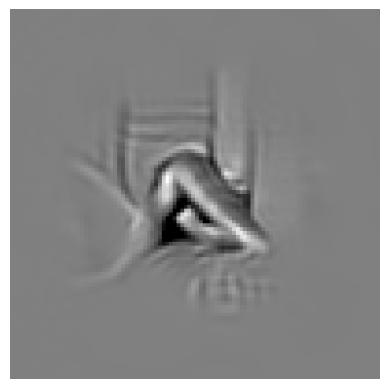

In [322]:
image = meis.iloc[i]['image']['path']
unit_idx = meis.iloc[i]['unit_idx']

run = api.run(f"sinzlab/egg/c0yeuwwy")

image = torch.Tensor(np.array(Image.open(run.file(image).download(exist_ok=True).name)))
image = image.mean(-1, keepdim=True) / 255 - 0.5
image_1 = image - image[0, 0]

plt.imshow(image_1.squeeze(), cmap='gray')
plt.axis('off')


Text(0.5, 1.0, 'nMEI')

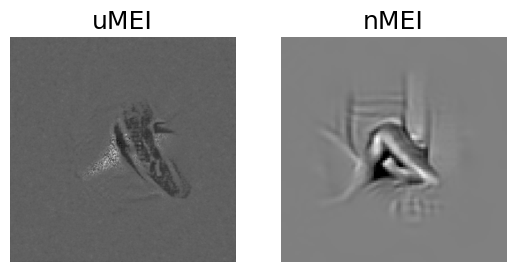

In [324]:
umei = meisn.query(f'unit_idx == {unit_idx}')
image = umei.iloc[0]['image']['path']

run = api.run(f"sinzlab/egg/q1v64jln")

image = torch.Tensor(np.array(Image.open(run.file(image).download(exist_ok=True).name)))
image = image.mean(-1, keepdim=True) / 255 - 0.5
image = image - image[0, 0]

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.title('uMEI')
plt.subplot(1, 2, 2)
plt.imshow(image_1.squeeze(), cmap='gray')
plt.axis('off')
plt.title('nMEI')


In [306]:
acts

[[3.206286668777466, 2.1879823207855225],
 [5.286301612854004, 7.194732189178467],
 [93.79640197753906, 29.598682403564453],
 [9.478764533996582, 26.597888946533203],
 [10.370750427246094, 11.13170051574707],
 [53.584373474121094, 34.40609359741211],
 [8.716691017150879, 8.417725563049316],
 [213.71469116210938, 123.7231216430664],
 [74.5666275024414, 71.97943878173828],
 [41.84823226928711, 31.142745971679688],
 [13.06110954284668, 11.260371208190918],
 [11.832968711853027, 9.03160572052002],
 [7.463330268859863, 5.606766223907471],
 [147.46047973632812, 83.34593963623047],
 [75.55486297607422, 23.28636360168457],
 [24.08344078063965, 15.242813110351562],
 [36.99999237060547, 13.263884544372559],
 [11.152680397033691, 12.42265796661377],
 [10.40966796875, 10.404047012329102],
 [26.38250732421875, 34.051048278808594],
 [109.0527572631836, 37.910675048828125],
 [145.96011352539062, 75.5038833618164],
 [24.841415405273438, 29.385278701782227],
 [6.281708240509033, 5.6551194190979],
 [12.

Text(0, 0.5, 'Unconstrained')

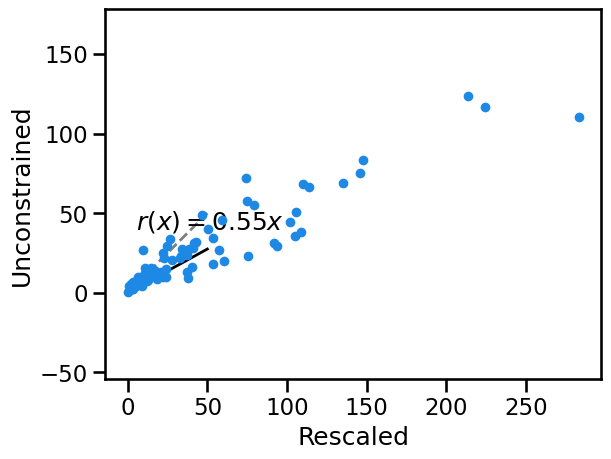

In [315]:
plot(np.array(acts)[..., 0], np.array(acts)[..., 1])
plt.xlabel('Rescaled')
plt.ylabel('Unconstrained')

seed  unit_idx      train       val  cross-val  \
79     0        88 -11.131701 -4.424121  -2.673841   

                                                image        norm  
79  {'sha256': '344367d5589985be824030dbb3d4c152c3...  171.358627

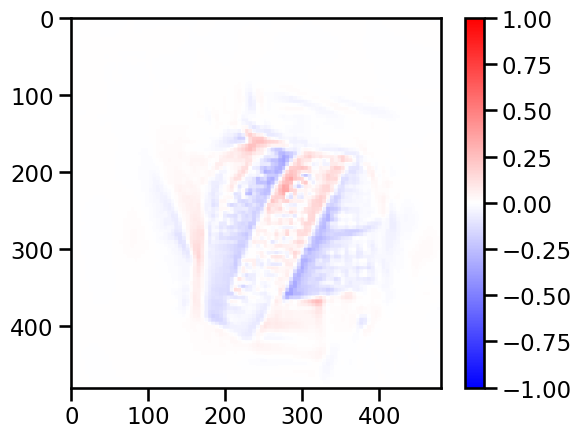

In [268]:
plt.imshow(image, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

In [194]:
# meino_norm_history = get_scores("busguvsm")
meino_norm_history = get_scores("q1v64jln")
idx = meino_norm_history.groupby(["unit_idx"])["train"].idxmin()
meino_norm_history = meino_norm_history.loc[idx, ["norm"]]
meino_norm_history['norm'].describe()

count      90.000000
mean      423.384873
std       500.712880
min        47.191593
25%       128.358456
50%       209.322975
75%       428.990929
max      2161.575928
Name: norm, dtype: float64

In [186]:
# meino_norm_history = get_scores("dpetgyzq")
meino_norm_history = get_scores("v2n7hpzh")
idx = meino_norm_history.groupby(["unit_idx"])["train"].idxmin()
meino_norm_history = meino_norm_history.loc[idx, ["norm"]]
meino_norm_history['norm'].describe()

count     90.000000
mean      79.085296
std       17.689984
min       27.940990
25%       65.906301
50%       82.547024
75%       90.838627
max      117.391197
Name: norm, dtype: float64

In [159]:
meisn

seed_sgd  unit_idx  train_sgd    val_sgd  cross-val_sgd  \
0          0         4   2.152424   1.328314       0.143225   
1          2        24   3.999077   3.846914       1.242516   
2          1        39   6.789780   6.718709       3.339290   
3          1        40  19.389051  19.231440       8.166248   
4          2        88   7.056406   6.967613       3.738895   
..       ...       ...        ...        ...            ...   
85         0      1193   3.396201   3.073324       1.183606   
86         2      1217   5.093489   4.827452       1.026444   
87         1      1219  33.122181  33.010471      19.395054   
88         0      1221  15.867764  15.553678       7.702597   
89         2      1234  10.532390   9.434464       0.815154   

                                            image_sgd  seed_w     train_w  \
0   {'size': 16180, 'height': 480, 'width': 480, '...       2   -2.876233   
1   {'sha256': '9073e7d96da5f0be0ac0ad405de533abec...       1   -7.898363   
2   {'size': 10957, 'height': 480, 'width': 480, '...       2  -32.199951   
3   {'width': 480, '_type': 'image-file', 'format'...       0  -26.597889   
4   {'_type': 'image-file', 'format': 'png', 'path...       1  -11.188430   
..                                                ...     ...         ...   
85  {'format': 'png', 'path': 'media/images/image_...       0   -4.259216   
86  {'format': 'png', 'path': 'media/images/image_...       1  -10.145926   
87  {'format': 'png', 'path': 'media/images/image_...       2 -247.365799   
88  {'size': 10677, 'height': 480, 'width': 480, '...       0 -110.612022   
89  {'height': 480, 'width': 480, '_type': 'image-...       1  -28.958368   

       val_w  cross-val_w                                            image_w  
0  -0.452158    -0.234227  {'format': 'png', 'path': 'media/images/image_...  
1  -2.265582    -1.219772  {'_type': 'image-file', 'format': 'png', 'path...  
2  -1.704204    -1.757687  {'sha256': 'e2fd9d27a86eef6b646addd6042e55bff9...  
3  -8.526965    -6.528468  {'path': 'media/images/image_33_234e3a422eb12d...  
4  -4.516236    -3.039725  {'path': 'media/images/image_179_04d9b876c68cd...  
..       ...          ...                                                ...  
85 -1.300074    -1.098968  {'_type': 'image-file', 'format': 'png', 'path...  
86 -0.475748    -0.298371  {'size': 188564, 'height': 480, 'width': 480, ...  
87 -7.528383    -9.494566  {'path': 'media/images/image_241_53b7ba2cd5bdb...  
88 -3.853298    -3.282174  {'sha256': '7e3f475a24fdf8e0aa0cb10c0b4ea74b7c...  
89 -1.002331    -1.782160  {'size': 288729, 'height': 480, 'width': 480, ...  

[90 rows x 11 columns]

In [128]:
# select meis100 that are not nan
# meis100 = meis100[~meis100['cross-val_1000'].isna()]
meisw

seed_sgd  unit_idx  train_sgd    val_sgd  cross-val_sgd  \
0          0         4   2.152424   1.328314       0.143225   
1          2        24   3.999077   3.846914       1.242516   
2          1        39   6.789780   6.718709       3.339290   
3          1        40  19.389051  19.231440       8.166248   
4          2        88   7.056406   6.967613       3.738895   
..       ...       ...        ...        ...            ...   
78         1      1187  12.631814  12.955627       2.684189   
79         0      1193   3.396201   3.073324       1.183606   
80         2      1217   5.093489   4.827452       1.026444   
81         1      1219  33.122181  33.010471      19.395054   
82         2      1234  10.532390   9.434464       0.815154   

                                            image_sgd  seed_w    train_w  \
0   {'sha256': 'c21f8e5cf4d5099f0676c2d7f9751ccbdb...       0   1.425804   
1   {'format': 'png', 'path': 'media/images/image_...       0   2.655971   
2   {'sha256': 'da485a50cc876bf01abeaa3032ae9f2596...       0   4.259389   
3   {'size': 13284, 'height': 480, 'width': 480, '...       2  14.867198   
4   {'_type': 'image-file', 'format': 'png', 'path...       1   4.716000   
..                                                ...     ...        ...   
78  {'width': 480, '_type': 'image-file', 'format'...       2   6.935867   
79  {'_type': 'image-file', 'format': 'png', 'path...       1   2.059255   
80  {'path': 'media/images/image_116_d93101dcdfe98...       2   3.023522   
81  {'size': 12909, 'height': 480, 'width': 480, '...       0  25.026548   
82  {'size': 11354, 'height': 480, 'width': 480, '...       2   5.021354   

        val_w  cross-val_w                                            image_w  
0    1.028160     0.184153  {'path': 'media/images/image_258_b2e03c9619161...  
1    2.547354     0.656815  {'height': 480, 'path': 'media/images/image_19...  
2    4.184490     1.887874  {'width': 480, '_type': 'image-file', 'format'...  
3   14.613832     5.923683  {'height': 480, 'path': 'media/images/image_10...  
4    4.622221     2.555915  {'width': 480, '_type': 'image-file', 'format'...  
..        ...          ...                                                ...  
78   6.910458     4.082904  {'sha256': 'd370557b9053406638fb6f16b2d3c5426c...  
79   1.891734     1.012699  {'size': 17410, 'width': 480, '_type': 'image-...  
80   2.839091     0.481929  {'height': 480, 'path': 'media/images/image_11...  
81  24.696339    12.365653  {'path': 'media/images/image_123_5a952d035f68f...  
82   4.380646     0.820712  {'_type': 'image-file', 'format': 'png', 'heig...  

[83 rows x 11 columns]

In [5]:
history

_timestamp                                              image  \
0    1.683812e+09  {'sha256': 'eacdffb1cc63df056a1dd8a2f2e5c44c64...   
1    1.683812e+09  {'width': 480, '_type': 'image-file', 'format'...   
2    1.683812e+09  {'height': 480, 'width': 480, '_type': 'image-...   
3    1.683812e+09  {'_type': 'image-file', 'format': 'png', 'path...   
4    1.683813e+09  {'path': 'media/images/image_4_1e5c997a1b566d4...   
..            ...                                                ...   
295  1.683831e+09  {'sha256': '9f590a1fe84a84f4d8cbc8769eb5ca2843...   
296  1.683831e+09  {'sha256': '580ff23bce924ce870c6b3e09f9c651772...   
297  1.683831e+09  {'path': 'media/images/image_297_d58e336a547ac...   
298  1.683831e+09  {'height': 480, 'width': 480, '_type': 'image-...   
299  1.683831e+09  {'sha256': '99f6b3c052d1ff91bc9d0ecf12acd141d3...   

         train      _runtime  cross-val        val       time  unit_idx  seed  \
0   -27.925461     68.760785  -7.470356 -26.496582  56.120961       230     0   
1   -22.766987    124.684462 -11.782432 -22.572649  55.909321      1118     0   
2    -7.550495    180.534591  -3.642081  -7.398973  55.837168       901     0   
3   -15.592516    236.480541 -11.459971 -14.223554  55.932992       710     0   
4   -25.159756    292.500908 -15.415507 -24.694941  56.005562       237     0   
..         ...           ...        ...        ...        ...       ...   ...   
295  -0.641825  18728.702394  -0.082856  -0.604149  70.444555       527     2   
296  -9.765503  18799.233823  -9.518107  -9.186953  70.517482       106     2   
297  -6.016974  18869.841716  -3.203314  -5.668307  70.593633       376     2   
298 -35.231232  18940.678675 -29.904142 -33.393425  70.823241       490     2   
299 -23.426344  19011.553573  -6.363218 -23.219059  70.860960      1145     2   

     _step  
0        0  
1        1  
2        2  
3        3  
4        4  
..     ...  
295    295  
296    296  
297    297  
298    298  
299    299  

[300 rows x 10 columns]

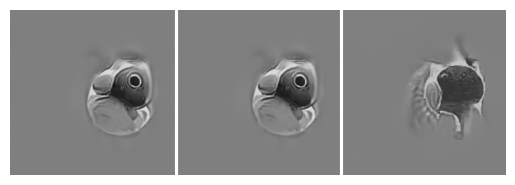

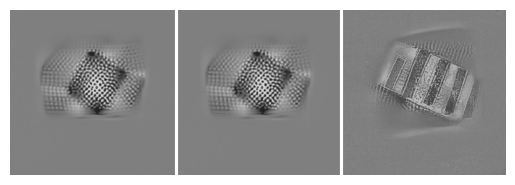

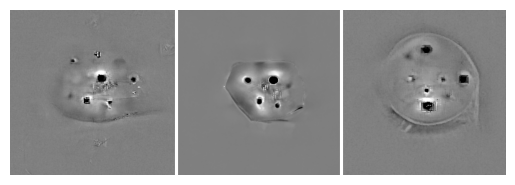

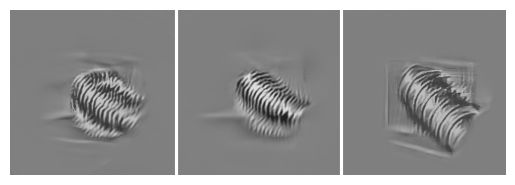

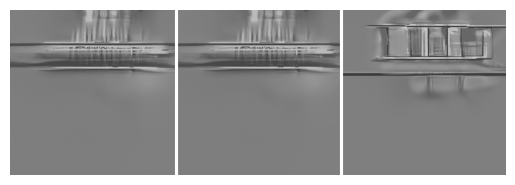

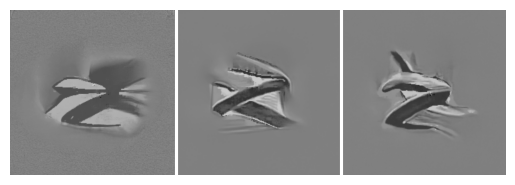

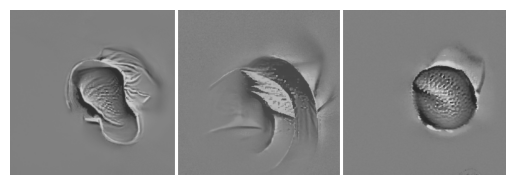

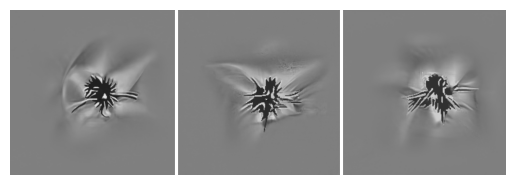

In [7]:
history = get_scores("edh6eed0")
api = wandb.Api()
units = [39, 230, 1118, 901, 710, 237, 177, 438]

for unit in units:
    images = history.query(f'unit_idx == {unit}')['image'].apply(lambda x: x['path'])
    run = api.run(f"sinzlab/egg/edh6eed0")
    images = [np.array(Image.open(run.file(image).download(exist_ok=True).name)) for image in images][:3]

    sns.set_context('talk')
    plt.imshow(np.hstack(images))
    plt.axvline(480, c='w')
    plt.axvline(480 * 2, c='w')
    plt.axis('off')
    plt.grid(False)
    plt.savefig(f'./results/egg_td_{unit}.png', dpi=150, bbox_inches='tight')
    plt.show()



In [53]:
history.query(f'unit_idx == {901}')

_timestamp                                              image  \
2    1.683812e+09  {'size': 77757, 'height': 480, 'width': 480, '...   
102  1.683818e+09  {'width': 480, '_type': 'image-file', 'format'...   
202  1.683825e+09  {'sha256': 'bec2038752b05faf935d352255d1ea393f...   

        train      _runtime  cross-val       val       time  unit_idx  seed  \
2   -7.550495    180.534591  -3.642081 -7.398973  55.837168       901     0   
102 -7.568412   6025.611618  -3.959420 -7.374913  60.798877       901     1   
202 -7.237646  12368.127361  -3.444233 -7.029560  65.937171       901     2   

     _step  
2        2  
102    102  
202    202

## Compare activations
*note: `cross-val_d` is stored negative*

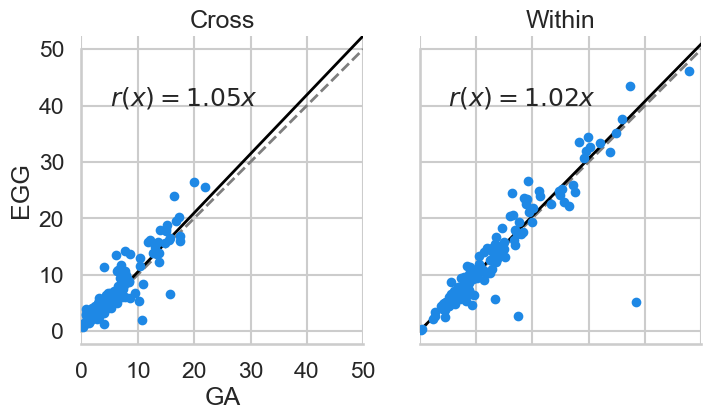

In [42]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot(mei_dime["cross-val_m"], -mei_dime["cross-val_d"])
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Cross")
plt.xlabel("GA")
plt.ylabel("EGG")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

plt.subplot(1, 2, 2)
plot(mei_dime["val_m"], -mei_dime["val_d"], c=palettes["candy"]["blue"])
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Within")

plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
plt.savefig("./activations.png", dpi=150, bbox_inches="tight")

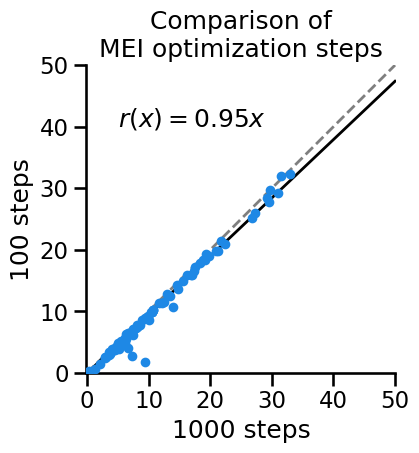

In [156]:
plt.style.use("default")
sns.set_context("talk")
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plot(meis100["val_1000"], meis100["val_100"])
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Comparison of\nMEI optimization steps")
plt.xlabel("1000 steps")
plt.ylabel("100 steps")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

# plt.subplot(1, 2, 2)
# plot(meis100["val_1000"], meis100["val_100"], c=palettes["candy"]["blue"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.title("Within")
#
# plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
# plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
plt.savefig("./activations_100v1000.png", dpi=150, bbox_inches="tight")

In [153]:
print("Within:", np.mean(meis100["val_100"]), np.mean(meis100["val_1000"]))
print("Within:", st.wilcoxon(meis100["val_100"], meis100["val_1000"]))

Within: 10.451488333940507 11.23215972483158
Within: WilcoxonResult(statistic=52.0, pvalue=9.805357404089941e-16)


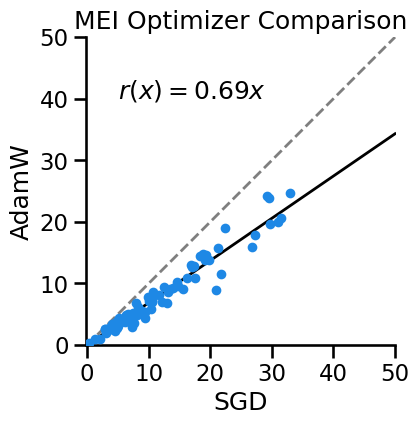

In [157]:
plt.style.use("default")
sns.set_context("talk")
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plot(meisw["val_sgd"], meisw["val_w"])
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("MEI Optimizer Comparison")
plt.xlabel("SGD")
plt.ylabel("AdamW")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

# plt.subplot(1, 2, 2)
# plot(meis100["val_1000"], meis100["val_100"], c=palettes["candy"]["blue"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.title("Within")
#
# plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
# plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
plt.savefig("./activations_adamw.png", dpi=150, bbox_inches="tight")

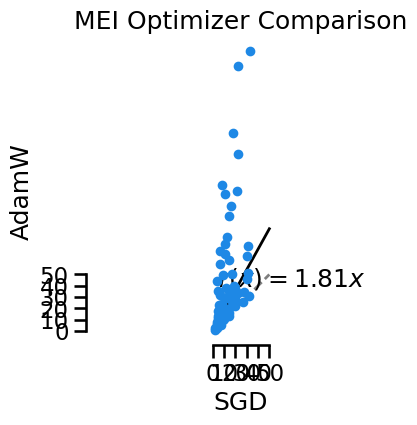

In [195]:
plt.style.use("default")
sns.set_context("talk")
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plot(meisn["train_sgd"], -meisn["train_w"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
plt.title("MEI Optimizer Comparison")
plt.xlabel("SGD")
plt.ylabel("AdamW")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

# plt.subplot(1, 2, 2)
# plot(meis100["val_1000"], meis100["val_100"], c=palettes["candy"]["blue"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.title("Within")
#
# plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
# plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
# plt.savefig("./activations_adamw.png", dpi=150, bbox_inches="tight")

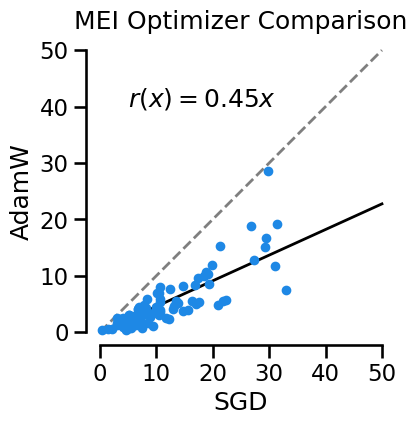

In [162]:
plt.style.use("default")
sns.set_context("talk")
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plot(meisn["val_sgd"], -meisn["val_w"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
plt.title("MEI Optimizer Comparison")
plt.xlabel("SGD")
plt.ylabel("AdamW")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

# plt.subplot(1, 2, 2)
# plot(meis100["val_1000"], meis100["val_100"], c=palettes["candy"]["blue"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.title("Within")
#
# plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
# plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
# plt.savefig("./activations_adamw.png", dpi=150, bbox_inches="tight")

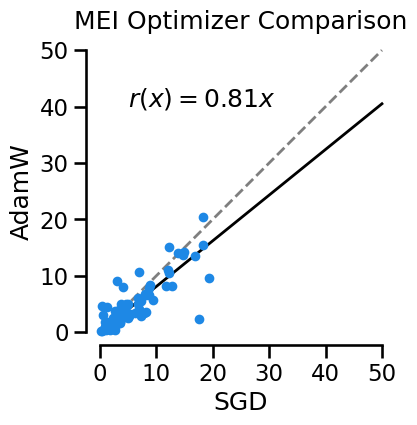

In [163]:
plt.style.use("default")
sns.set_context("talk")
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
plot(meisn["cross-val_sgd"], -meisn["cross-val_w"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
plt.title("MEI Optimizer Comparison")
plt.xlabel("SGD")
plt.ylabel("AdamW")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

# plt.subplot(1, 2, 2)
# plot(meis100["val_1000"], meis100["val_100"], c=palettes["candy"]["blue"])
# plt.xlim(0, 40)
# plt.ylim(0, 40)
# plt.title("Within")
#
# plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
# plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
# plt.savefig("./activations_adamw.png", dpi=150, bbox_inches="tight")

Check the means

In [43]:
print("Within:", np.mean(-mei_dime["val_d"]), np.mean(mei_dime["val_m"]))
print("Cross:", np.mean(-mei_dime["cross-val_d"]), np.mean(mei_dime["cross-val_m"]))

Within: 13.13308992634217 13.00302793910106
Cross: 7.6080992686748505 7.89781490902106


Check if they are significant

In [44]:
print("Within:", st.wilcoxon(-mei_dime["val_d"], mei_dime["val_m"]))
print("Cross:", st.wilcoxon(-mei_dime["cross-val_d"], mei_dime["cross-val_m"]))

Within: WilcoxonResult(statistic=4876.0, pvalue=0.1400345579841613)
Cross: WilcoxonResult(statistic=2456.0, pvalue=1.7860096460925233e-09)


## Plot MEI examples

In [45]:
mei_dime["ratio"] = -mei_dime["cross-val_d"] / mei_dime["cross-val_m"]
images = history.loc[idx, ["unit_idx", "image", "seed"]]

np.random.seed(1)
images = (
    mei_dime.sort_values("ratio", ascending=False).head(11).iloc[1:]
)  # mei_dime.sample(10)

api = wandb.Api()
run_d = api.run(f"sinzlab/egg/dxuyo5r1")
run_m = api.run(f"sinzlab/egg/h83eq1s8")

imgs_m = []
imgs_d = []
for image in images.iterrows():
    filename_m = image[1].image_m["path"]
    filename_d = image[1].image_d["path"]
    file_m = run_m.file(filename_m)
    file_d = run_d.file(filename_d)
    filename_m = file_m.download(exist_ok=True).name
    filename_d = file_d.download(exist_ok=True).name
    _img_m = Image.open(filename_m)
    _img_d = Image.open(filename_d)
    imgs_m.append(_img_m)
    imgs_d.append(_img_d)

KeyError: '[396, 446, 401, 377, 335, 403, 432, 348, 319, 302, 311, 361, 367, 409, 369, 344, 439, 386, 341, 420, 364, 346, 417, 395, 389, 336, 392, 447, 354, 379, 315, 441, 437, 325, 303, 307, 328, 405, 374, 413, 353, 322, 427, 423, 314, 382, 415, 431, 331, 357] not in index'

In [ ]:
img_d, img_m = np.hstack(imgs_d), np.hstack(imgs_m)
plt.figure(figsize=(18, 3))
plt.subplot(2, 1, 1)
plt.imshow(img_d)
plt.axis(False)

plt.subplot(2, 1, 2)
plt.imshow(img_m)
plt.axis(False)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)

plt.savefig("./diffmeis.png", dpi=150, bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
plt.imshow(img_m)
plt.axis(False)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("./diffmei_examples.png", dpi=150, bbox_inches="tight", pad_inches=0)

## Check compute performance

In [ ]:
api = wandb.Api()
run = api.run(f"sinzlab/egg/fszcg6wz")

time = run.history()["time"]
mu_d, se_d = time.mean(), time.std() / np.sqrt(len(time))

api = wandb.Api()
run = api.run(f"sinzlab/egg/vjcc5k8r")

time = run.history()["time"]
mu_m, se_m = time.mean(), time.std() / np.sqrt(len(time))

In [ ]:
sns.set_context("talk")
plt.figure(figsize=(3, 3), dpi=150, facecolor="w")
plt.bar(
    [0, 1],
    [mu_d, mu_m],
    yerr=[se_d, se_m],
    color=[palettes["candy"]["yellow"], palettes["candy"]["green"]],
    edgecolor="k",
    linewidth=3,
)

plt.xlim(-0.5, 1.5)

plt.xticks([-0.5, 0, 1, 1.5], ["", "EGG", "GA", ""])
plt.yticks([0, 50, 100, 150, 200, 250])

plt.text(
    0,
    mu_d + 5,
    f"{mu_d:.0f}s $\pm$ {se_d:.2f}",
    horizontalalignment="center",
    fontsize=11,
)
plt.text(
    1,
    mu_m + 5,
    f"{mu_m:.0f}s $\pm$ {se_m:.2f}",
    horizontalalignment="center",
    fontsize=11,
)

plt.ylabel("Generation time (s)")

sns.despine(trim=True)
plt.savefig("./performance.pdf", dpi=150, bbox_inches="tight")

# Data-Driven CNN + Attention Readout Model

## Get Data

In [ ]:
dime_history = get_scores("ccoztu9h")
idx = dime_history.groupby(["unit_idx"])["train"].idxmin()
dimes = dime_history.loc[
    idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]
]

mei_history = get_scores("jk3fgqnn")
idx = mei_history.groupby(["unit_idx"])["train"].idxmin()
meis = mei_history.loc[idx, ["seed", "unit_idx", "train", "val", "cross-val", "image"]]

mei_dime = dimes.merge(meis, on="unit_idx", how="right", suffixes=["_d", "_m"])
mei_dime = mei_dime.merge(data_driven_corrs, left_on="unit_idx", right_on="unit_id")

In [33]:
history

train     _runtime        val  \
0   -15.094795    23.458699 -12.427020   
1   -20.282036    41.808451 -15.240091   
2    -8.102470    60.153669  -5.779263   
3   -13.778628    78.512203 -12.002468   
4   -26.362196    96.907471 -21.988943   
..         ...          ...        ...   
295  -2.379150  6587.898725  -1.769375   
296 -10.080478  6614.134147  -9.204835   
297  -7.390562  6640.411180  -6.790470   
298 -39.443455  6666.777875 -35.415283   
299 -31.142553  6693.115889 -26.804998   

                                                 image       time  unit_idx  \
0    {'format': 'png', 'path': 'media/images/image_...  18.321100       230   
1    {'_type': 'image-file', 'format': 'png', 'path...  18.340499      1118   
2    {'size': 182913, 'height': 480, 'width': 480, ...  18.336510       901   
3    {'height': 480, 'width': 480, '_type': 'image-...  18.350820       710   
4    {'size': 152184, 'height': 480, 'width': 480, ...  18.386814       237   
..                                                 ...        ...       ...   
295  {'path': 'media/images/image_295_a3d49b01673dd...  26.237139       527   
296  {'size': 63790, 'height': 480, 'width': 480, '...  26.227384       106   
297  {'width': 480, '_type': 'image-file', 'format'...  26.267324       376   
298  {'sha256': '81d30a63766639aee6f6cdfd2f20f90d26...  26.357491       490   
299  {'sha256': 'f0706c4017a35792ba308a8a9321d9ef24...  26.329985      1145   

     cross-val    _timestamp  seed  _step  
0   -11.498916  1.684264e+09     0      0  
1   -10.413447  1.684264e+09     0      1  
2    -3.579188  1.684264e+09     0      2  
3    -3.660782  1.684264e+09     0      3  
4   -12.586563  1.684264e+09     0      4  
..         ...           ...   ...    ...  
295  -0.159343  1.684271e+09     2    295  
296  -6.313729  1.684271e+09     2    296  
297  -2.719458  1.684271e+09     2    297  
298 -17.251740  1.684271e+09     2    298  
299 -12.200902  1.684271e+09     2    299  

[300 rows x 10 columns]

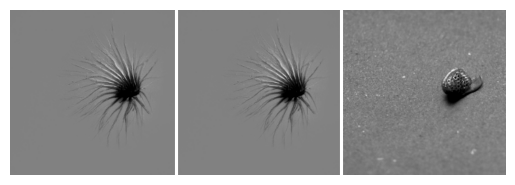

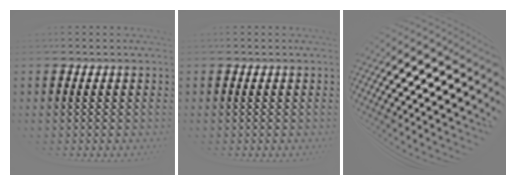

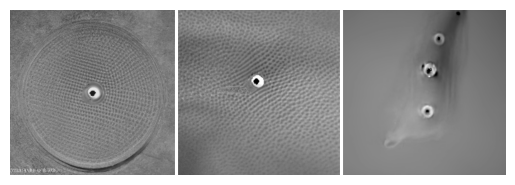

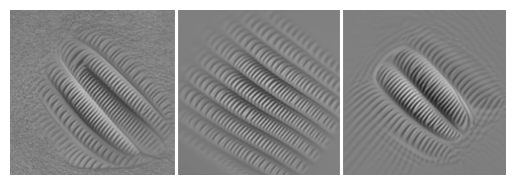

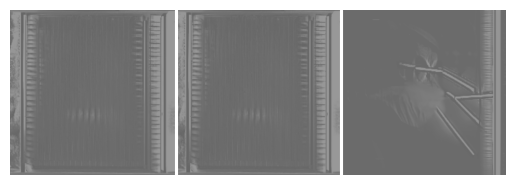

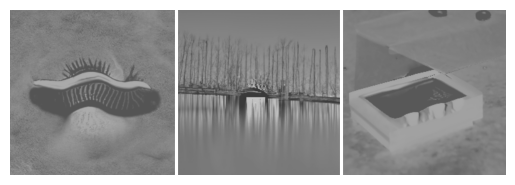

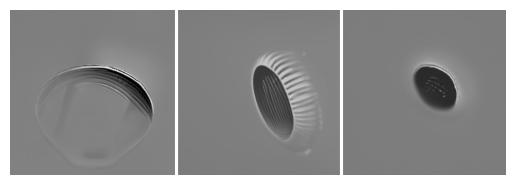

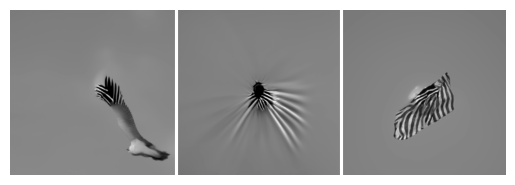

In [8]:
api = wandb.Api()
history = get_scores("ccoztu9h")
units = [39, 230, 1118, 901, 710, 237, 177, 438]

for unit in units:
    images = history.query(f'unit_idx == {unit}')['image'].apply(lambda x: x['path'])
    run = api.run(f"sinzlab/egg/ccoztu9h")
    images = [np.array(Image.open(run.file(image).download(exist_ok=True).name)) for image in images][:3]

    sns.set_context('talk')
    plt.imshow(np.hstack(images))
    plt.axvline(480, c='w')
    plt.axvline(480 * 2, c='w')
    plt.axis('off')
    plt.grid(False)
    plt.savefig(f'./results/egg_{unit}.png', dpi=150, bbox_inches='tight')
    plt.show()



## Compare activations

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot(
    mei_dime["cross-val_m"],
    -mei_dime["cross-val_d"],
    text_y=40,
    c=palettes["candy"]["pink"],
)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.title("Cross")
plt.xlabel("GA")
plt.ylabel("EGG")

plt.yticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])

plt.subplot(1, 2, 2)
plot(mei_dime["val_m"], -mei_dime["val_d"], c=palettes["candy"]["pink"], text_y=40)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.title("Within")

plt.yticks([0, 10, 20, 30, 40, 50], [""] * 6)
plt.xticks([0, 10, 20, 30, 40, 50], [""] * 6)

sns.despine(trim=True)
plt.savefig("./activations_attn.png", dpi=150, bbox_inches="tight")

Check the means

In [ ]:
print("Within:", np.mean(-mei_dime["val_d"]), np.mean(mei_dime["val_m"]))
print("Cross:", np.mean(-mei_dime["cross-val_d"]), np.mean(mei_dime["cross-val_m"]))

Check if they are significant

In [ ]:
print("Within:", st.wilcoxon(-mei_dime["val_d"], mei_dime["val_m"]))
print("Cross:", st.wilcoxon(-mei_dime["cross-val_d"]), np.mean(mei_dime["cross-val_m"]))

## Get examples

In [ ]:
images = mei_dime
images_m = images["image_m"]
images_d = images["image_d"]

api = wandb.Api()
run_m = api.run(f"sinzlab/egg/jk3fgqnn")
run_d = api.run(f"sinzlab/egg/ccoztu9h")

imgs_m = []
for image in images_m:
    path = image["path"]
    file = run_m.file(path).download(exist_ok=True).name
    _img_m = Image.open(file)
    imgs_m.append(np.array(_img_m))

imgs_d = []
for image in images_d:
    path = image["path"]
    file = run_d.file(path).download(exist_ok=True).name
    _img_d = Image.open(file)
    imgs_d.append(np.array(_img_d))

imgs_d = np.array(imgs_d).reshape(9, 10, 480, 480, 4)
imgs_m = np.array(imgs_m).reshape(9, 10, 480, 480, 4)

In [ ]:
selected_d = np.hstack(
    [
        imgs_d[7][3],
        imgs_d[6][7],
        imgs_d[5][0],
        imgs_d[5][1],
        imgs_d[5][8],
        imgs_d[4][6],
        imgs_d[8][0],
        imgs_d[4][8],
        imgs_d[6][5],
        imgs_d[0][5],
    ]
)
selected_m = np.hstack(
    [
        imgs_m[7][3],
        imgs_m[6][7],
        imgs_m[5][0],
        imgs_m[5][1],
        imgs_m[5][8],
        imgs_m[4][6],
        imgs_m[8][0],
        imgs_m[4][8],
        imgs_m[6][5],
        imgs_m[0][5],
    ]
)
selected = np.vstack([selected_d, selected_m])

In [ ]:
plt.figure(dpi=150, figsize=(18, 3))
plt.imshow(selected)

plt.axis(False)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.savefig("./diffmei_attn.png", dpi=150, bbox_inches="tight", pad_inches=0)

In [116]:
with open('../data/data_driven_corrs.pkl', 'rb') as f:
    data_driven_corrs = pickle.load(f)

dime_history = get_scores('ccoztu9h')
# dime_history = get_scores('ojl4y4ur')
idx = dime_history.groupby(['unit_idx'])['train'].idxmin()
dimes = dime_history.loc[idx, ['seed', 'unit_idx', 'train', 'val', 'cross-val', 'image']]
print(len(dimes))

# mei_history = get_scores('9ocukde7')
mei_history = get_scores('jk3fgqnn')
idx = mei_history.groupby(['unit_idx'])['train'].idxmin()
meis = mei_history.loc[idx, ['seed', 'unit_idx', 'train', 'val', 'cross-val', 'image']]
print(len(meis))

mei_dime = dimes.merge(meis, on='unit_idx', how='right', suffixes=['_d', '_m'])

mei_dime = dimes.merge(meis, on='unit_idx', how='right', suffixes=['_d', '_m'])
mei_dime = mei_dime.merge(data_driven_corrs, left_on='unit_idx', right_on='unit_id')

images = mei_dime#.query('val_m + val_d > 1').loc[[26, 40, 41]]
images_m = images['image_m']
images_d = images['image_d']

api = wandb.Api()
# run_m = api.run(f'sinzlab/egg/jk3fgqnn')
# run_d = api.run(f'sinzlab/egg/o747gxb9')
# run_d = api.run(f'sinzlab/egg/ojl4y4ur')
run_d = api.run(f'sinzlab/egg/ccoztu9h')
# c0yeuwwy

imgs_m = []
# for image in images_m:
#     path = image['path']
#     file = run_m.file(path).download(exist_ok=True).name
#     _img_m = Image.open(file)
#     imgs_m.append(np.array(_img_m))

imgs_d = []
for image in images_d:
    path = image['path']
    file = run_d.file(path).download(exist_ok=True).name
    _img_d = Image.open(file)
    imgs_d.append(np.array(_img_d))

# img = np.hstack([np.vstack(imgs_d), np.vstack(imgs_m)])
imgs_d = np.array(imgs_d).reshape(9, 10, 480, 480, 4)
# imgs_m = np.array(imgs_m).reshape(9, 10, 480, 480, 4)

90
90


In [ ]:
img_d = np.hstack(imgs_d)
img_d = np.hstack(img_d)
plt.figure(dpi=150, figsize=(10, 10))
plt.imshow(img_d)
plt.axis(False)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
plt.margins(0,0)
# plt.savefig('./all_attn.png', dpi=150, pad_inches=0)

In [119]:
from scipy.optimize import curve_fit

i = np.abs(imgs_d / 255 * 2 - 1)[..., 0]
i = np.vstack(i)
i[i > 0.25] = 1
i[i < 0.25] = 0

def gaussian_2d(xy, amplitude, xo, yo, sigma):
    sigma_x = sigma
    sigma_y = sigma
    theta = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x ** 2) + (np.sin(theta) ** 2) / (2 * sigma_y ** 2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x ** 2) + (np.sin(2 * theta)) / (4 * sigma_y ** 2)
    c = (np.sin(theta) ** 2) / (2 * sigma_x ** 2) + (np.cos(theta) ** 2) / (2 * sigma_y ** 2)
    g = amplitude * np.exp(- (a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2)))
    return g.ravel()

x, y = np.meshgrid(np.arange(0, 480), np.arange(0, 480))
x_data = x.ravel()
y_data = y.ravel()

# Initial guess for the parameters
initial_guess = (1, 240, 240, 50)

# Perform the curve fitting
sigmas = []
for idx in range(90):
    z_data = i[idx].ravel()
    popt, _ = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)
    amplitude, xo, yo, sigma = popt
    sigmas.append(sigma)

att_sigmas = sigmas.copy()

np.mean(sigmas)

49.61821005932738

In [99]:
i = np.abs(imgs_d / 255 * 2 - 1)
i = np.hstack(i)
i = np.hstack(i)

sigma = 1

import skimage
import skimage.filters
# apply Gaussian blur, creating a new image
i = skimage.filters.gaussian(
    i, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)


i[i > 0.25] = 1
i[i < 0.25] = 0

In [100]:
i = np.abs(imgs_d[..., 0] / 255 * 2 - 1)
i[i > 0.25] = 1
i[i < 0.25] = 0
i = np.vstack(i)
# i = np.hstack(i)

coordinates_list = [np.where(image) for image in i]
std_coordinates_list = [np.std(coords, axis=1) for coords in coordinates_list]
np.nanmean(std_coordinates_list)

/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


55.135328224870264

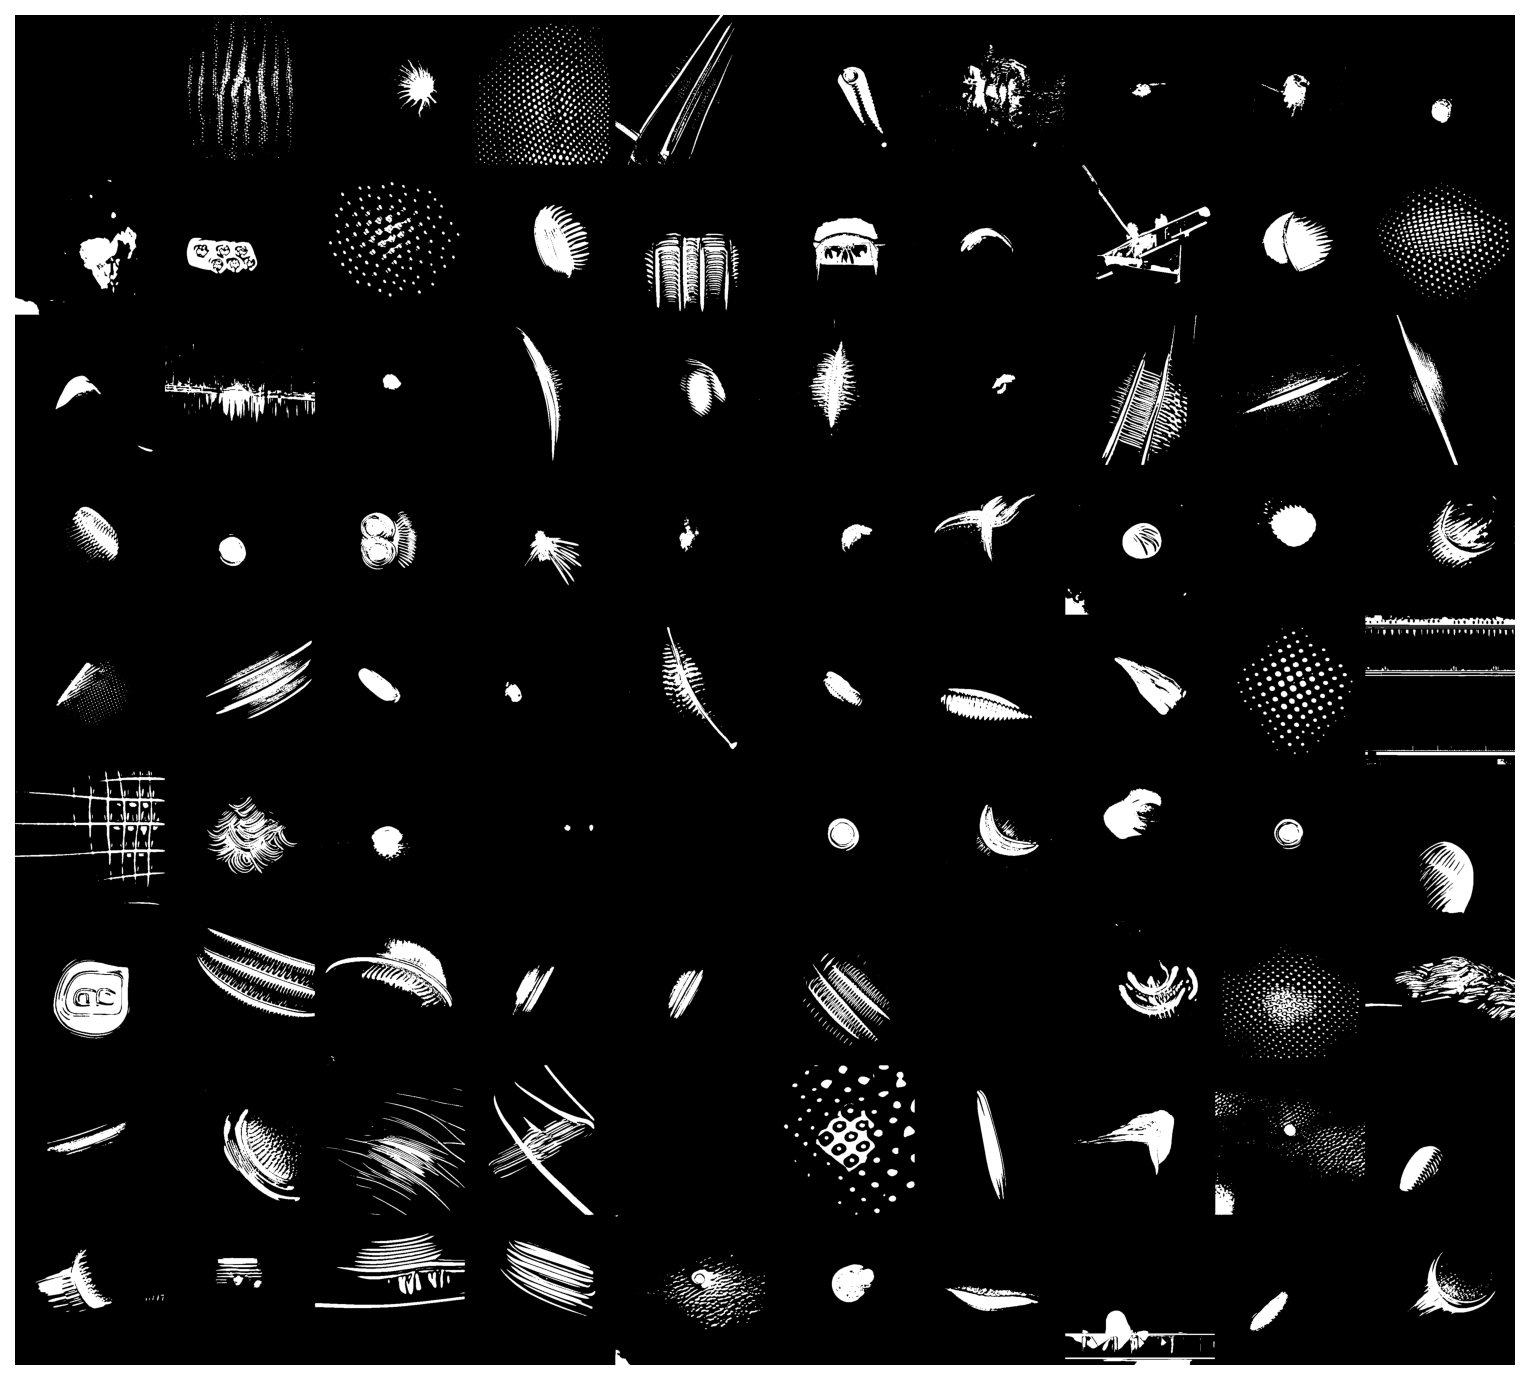

In [68]:
plt.figure(dpi=150, figsize=(10, 10))
plt.imshow(i)
plt.axis(False)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
plt.margins(0,0)
# plt.savefig('./maskwd.png', dpi=150, pad_inches=0)

In [69]:
i.sum() / np.prod(i.shape)

0.29539695457175924

In [120]:
with open('../data/data_driven_corrs.pkl', 'rb') as f:
    data_driven_corrs = pickle.load(f)
dime_history = get_scores('edh6eed0')
# dime_history = get_scores('ojl4y4ur')
idx = dime_history.groupby(['unit_idx'])['train'].idxmin()
dimes = dime_history.loc[idx, ['seed', 'unit_idx', 'train', 'val', 'cross-val', 'image']]
print(len(dimes))

# mei_history = get_scores('9ocukde7')
mei_history = get_scores('c0yeuwwy')
idx = mei_history.groupby(['unit_idx'])['train'].idxmin()
meis = mei_history.loc[idx, ['seed', 'unit_idx', 'train', 'val', 'cross-val', 'image']]
print(len(meis))

mei_dime = dimes.merge(meis, on='unit_idx', how='right', suffixes=['_d', '_m'])
mei_dime = mei_dime.merge(data_driven_corrs, left_on='unit_idx', right_on='unit_id')

images = mei_dime#.query('val_m + val_d > 1').loc[[26, 40, 41]]
images_d = images['image_d']

api = wandb.Api()
run_d = api.run(f'sinzlab/egg/edh6eed0')
# c0yeuwwy

imgs_d = []
for image in images_d:
    path = image['path']
    print(path)
    file = run_d.file(path).download(exist_ok=True).name
    _img_d = Image.open(file)
    imgs_d.append(np.array(_img_d))

# img = np.hstack([np.vstack(imgs_d), np.vstack(imgs_m)])
imgs_d = np.array(imgs_d).reshape(9, 10, 480, 480, 4)

90
90
media/images/image_86_ce55e0107810a7fdd98e.png
media/images/image_265_354bb43d18f5a48946bd.png
media/images/image_7_4821c115bcef0e2154a8.png
media/images/image_233_9995f9efc67d0611fdf6.png
media/images/image_279_f7bf8ccb0e92da610f5b.png
media/images/image_196_4a6f6f51122f115606bd.png
media/images/image_37_a7fc02af38be0b97551c.png
media/images/image_283_deb3158c0cab93738641.png
media/images/image_49_dac151f48ad145d14227.png
media/images/image_169_7efe6e40845df73aec2c.png
media/images/image_88_66b25e05064b248f9880.png
media/images/image_251_5ec2366c5ceb96f1c2c3.png
media/images/image_39_829fd4000c0d944338ea.png
media/images/image_205_6e6018cdb420384f4917.png
media/images/image_81_b111fbad6c09f7571b14.png
media/images/image_214_2a8507b6fb1b1f28a586.png
media/images/image_263_417f00034363b0cbc4f2.png
media/images/image_272_417bb80891d96c2d9eb2.png
media/images/image_116_e131e1acab78717620c9.png
media/images/image_0_eacdffb1cc63df056a1d.png
media/images/image_89_0988f2514b9988e63eaf.p

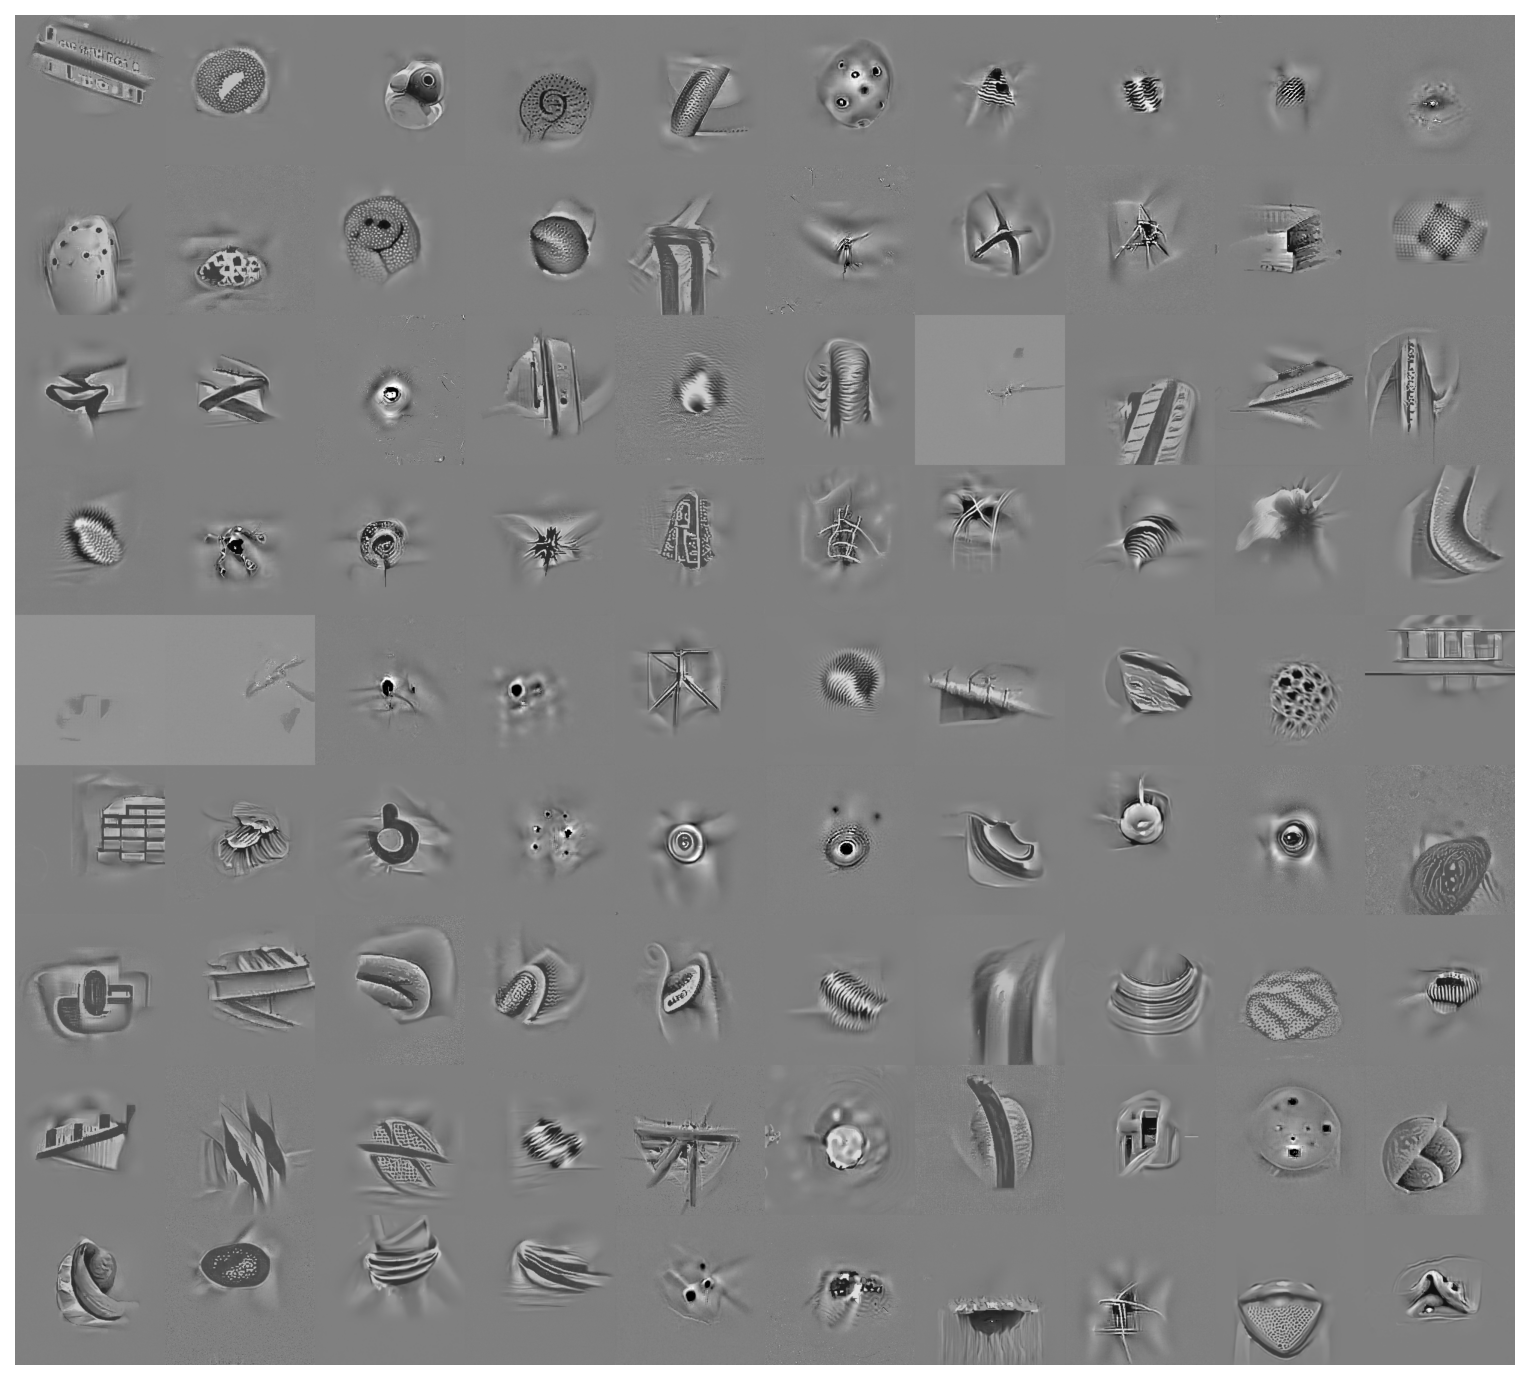

In [71]:
img_d = np.hstack(imgs_d)
img_d = np.hstack(img_d)
plt.figure(dpi=150, figsize=(10, 10))
plt.imshow(img_d)
plt.axis(False)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
plt.margins(0,0)
# plt.savefig('./all_attn.png', dpi=150, pad_inches=0)

In [121]:
from scipy.optimize import curve_fit

i = np.abs(imgs_d / 255 * 2 - 1)[..., 0]
i = np.vstack(i)
i[i > 0.25] = 1
i[i < 0.25] = 0

def gaussian_2d(xy, amplitude, xo, yo, sigma):
    sigma_x = sigma
    sigma_y = sigma
    theta = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x ** 2) + (np.sin(theta) ** 2) / (2 * sigma_y ** 2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x ** 2) + (np.sin(2 * theta)) / (4 * sigma_y ** 2)
    c = (np.sin(theta) ** 2) / (2 * sigma_x ** 2) + (np.cos(theta) ** 2) / (2 * sigma_y ** 2)
    g = amplitude * np.exp(- (a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2)))
    return g.ravel()

x, y = np.meshgrid(np.arange(0, 480), np.arange(0, 480))
x_data = x.ravel()
y_data = y.ravel()

# Initial guess for the parameters
initial_guess = (1, 240, 240, 50)

# Perform the curve fitting
sigmas = []
for idx in range(90):
    z_data = i[idx].ravel()
    popt, _ = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)
    amplitude, xo, yo, sigma = popt
    sigmas.append(sigma)

gauss_sigmas = sigmas.copy()

np.mean(sigmas)

/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


55.36090559518272

In [122]:
import scipy.stats as st

st.wilcoxon(att_sigmas, gauss_sigmas)

WilcoxonResult(statistic=1386.0, pvalue=0.007775403611927758)

In [72]:
i = np.abs(imgs_d / 255 * 2 - 1)
i = np.hstack(i)
i = np.hstack(i)

sigma = 1

import skimage
import skimage.filters
# apply Gaussian blur, creating a new image
i = skimage.filters.gaussian(
    i, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)


i[i > 0.25] = 1
i[i < 0.25] = 0

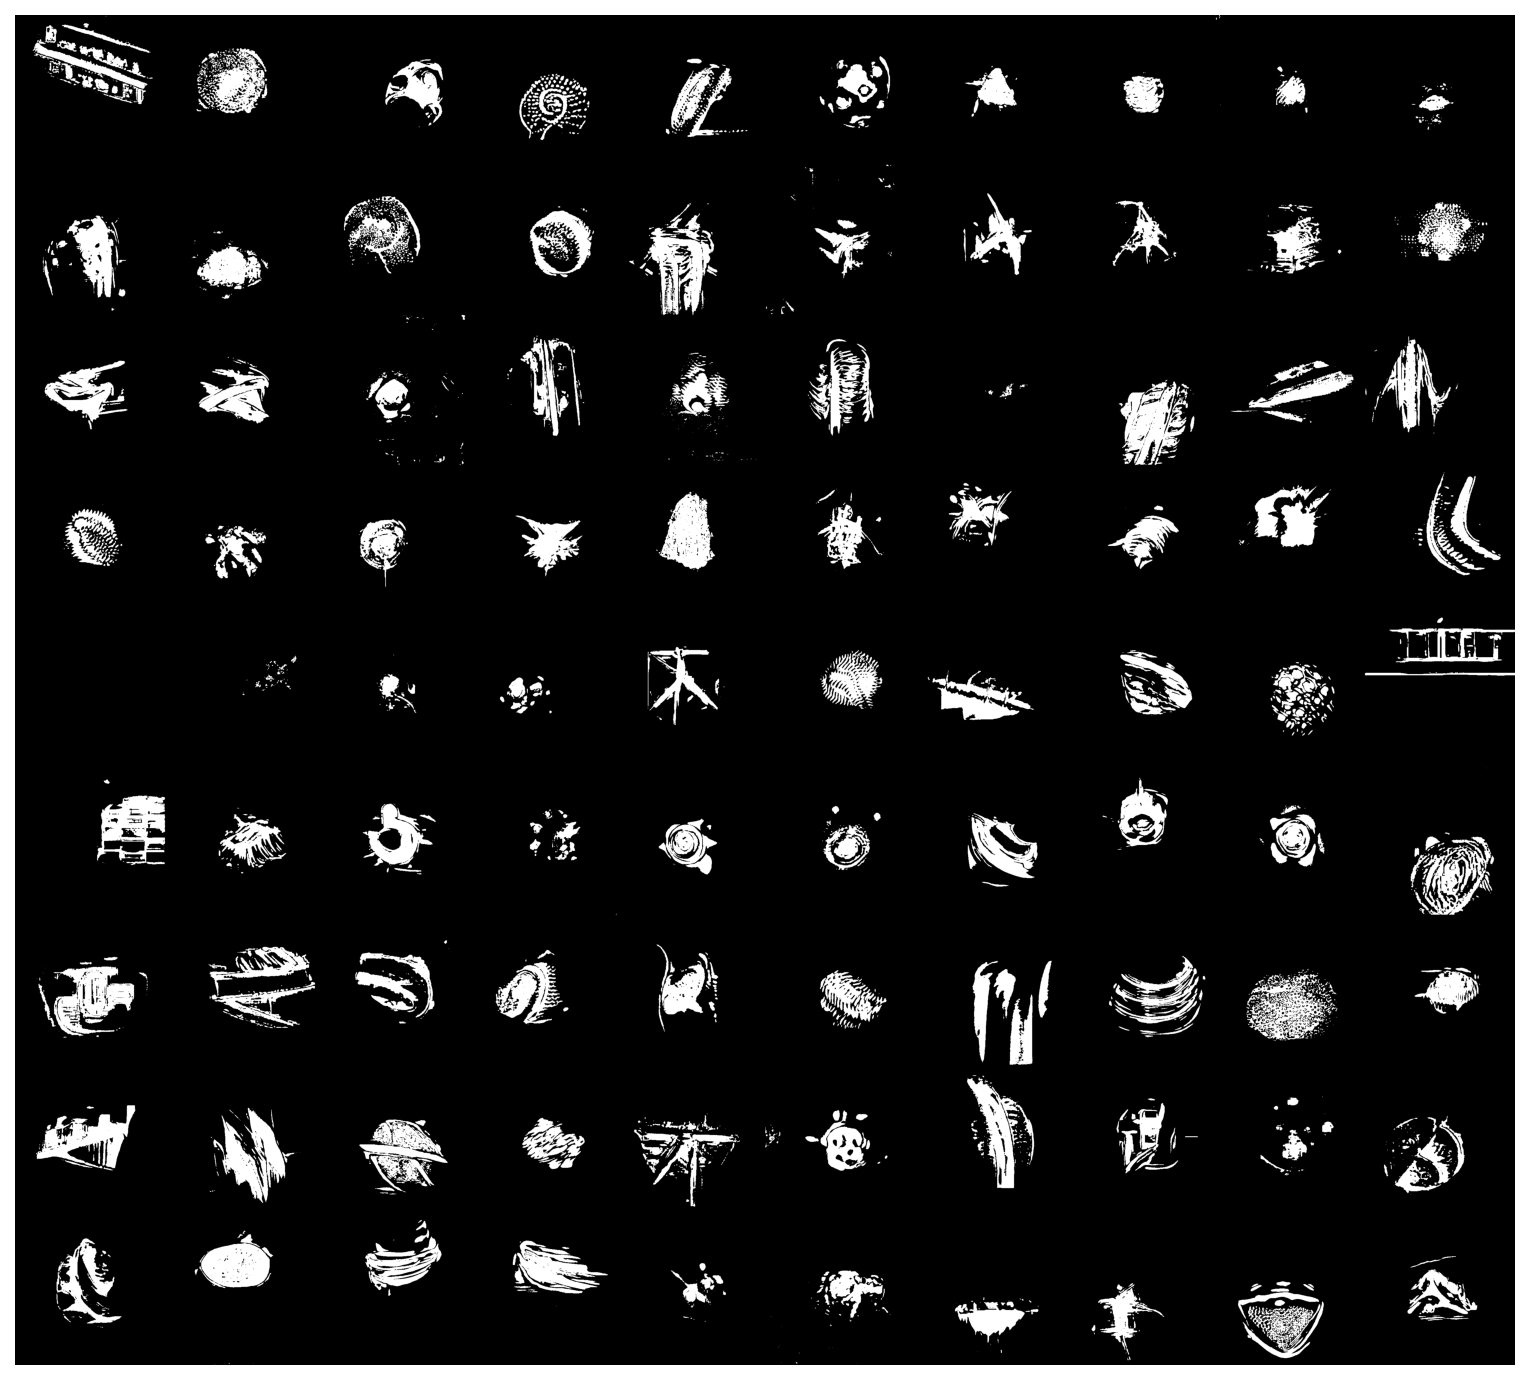

In [73]:
plt.figure(dpi=150, figsize=(10, 10))
plt.imshow(i)
plt.axis(False)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)
plt.margins(0,0)
# plt.savefig('./maskwd.png', dpi=150, pad_inches=0)

In [74]:
i.sum() / np.prod(i.shape)

0.3059087818287037

In [91]:
i = np.abs(imgs_d[..., 0] / 255 * 2 - 1)
i[i > 0.25] = 1
i[i < 0.25] = 0
i = np.vstack(i)
# i = np.hstack(i)

coordinates_list = [np.where(image) for image in i]
std_coordinates_list = [np.std(coords, axis=1) for coords in coordinates_list]

/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/paul/PycharmProjects/guided-diffusion/venv/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
 

In [96]:
np.nanmean(std_coordinates_list)

51.69520021411494